In [1]:
import os

import numpy as np
from numpy.linalg import norm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import xgboost as xgb
from pyemd import emd

from utils import get_hash
from utils import Featurizer
from utils import plot_confusion_matrix

## Word Embeddings
The featurizer will serve to create embeddings and compute similarity scores between answers and landmarks.

In [2]:
# Create a featurizer object that converts a phrase into embedding vector
emb_file = os.path.join('munge', 'GoogleNews-vectors-negative300.bin')
featurizer = Featurizer(emb_file)

Loading word vectors...
Done! Using 3000000 word vectors from pre-trained word2vec.


## Reading Data

We will be reading modeling and test data that were prepared using a random split during the preprocessing phase.  
The modeling set represents 80% from the instances in the original data.  
Because the data is small, we will be using a 10-fold evaluation strategy.  
The test set contrains the remaining 20% of the orignal data.

In [3]:
modeling = pd.read_csv(os.path.join('munge', 'modeling.csv'))
print('Found %d instances in modeling set.' %len(modeling))
test = pd.read_csv(os.path.join('munge', 'test.csv'))
print('Found %d instances in test set.' %len(test))

Found 718 instances in modeling set.
Found 180 instances in test set.


Landmarks are oservations from the training set, a mixture of student answers and reference answers.  
We will be using those landmarks to create similarity features using pre-trained word embeddings.    
The embeddings in the landmark dataset have already been computed during the preprocessing phase.

In [4]:
landmarks = pd.read_csv(os.path.join('munge', 'landmarks.txt'), sep="\t")
landmarks['embedding'] = landmarks['embedding'].apply(lambda x : list(map(float, x.split(','))))
print('Found %d landmarks.' %len(landmarks))
landmarks.head()

Found 227 landmarks.


,pd_hash,qu_hash,label,answer,embedding
0,b78a60db07,acdf3150fe,0,Newton's nd Law says that the net force is equ...,"[-0.0022924086626838237, 0.03636921153349035, ..."
1,b78a60db07,acdf3150fe,0,An object on which a net force is being applie...,"[0.03254292805989583, 0.01917724609375, 0.0371..."
2,b78a60db07,acdf3150fe,0,The net force equals mass times acceleration.,"[0.04997907366071429, 0.07972935267857142, 0.0..."
3,b78a60db07,acdf3150fe,0,Newton's second law says that net force equals...,"[-0.010182698567708334, 0.041910807291666664, ..."
4,b78a60db07,acdf3150fe,0,The sum of the forces equals mass times accele...,"[0.086700439453125, 0.097503662109375, 0.07733..."


## Feature Engineering

In [5]:
def get_features(landmarks, obs):
    """"Create all features to represent an observation.
    
    Args:
        landmarks : a dataframe of landmarks (output of preprocessing phase)
        obs : an observation (one row in train, dev or test dataframe)
    
    Returns:
        features : a numpy vector with float numbers
    """
        
    # Get observation values
    pd_hash = get_hash(obs['problem_description'])
    qu_hash = get_hash(obs['question'])
    emb = featurizer.doc2vec(obs['answer'])
        
    # Landmark of different question will get zero similarity (default)
    qu_land = landmarks.copy()
    qu_land['similarity'] = 0 # Compute cosine similarity with landmark
    qu_land['asym_diff_left'] = 0 # asymmetric difference between answer and landmark
    qu_land['asym_diff_right'] = 0 # asymmetric diffence between landmark and answer
    qu_land['word_match'] = 0 # word match between landmark and answer
    #qu_land['wmdist'] = 0 # world mover's distance between landmark and answer

    # Compute similarity when embedding is not zero and landmark from same question
    if norm(emb)!=0:
        # Get index of landmarks with same problem  and question 
        idx = qu_land[(qu_land['pd_hash']==pd_hash) & (qu_land['qu_hash']==qu_hash)].index
        # Compute the direct similarity with these landmarks
        qu_land.loc[idx, 'similarity'] = qu_land.loc[idx, 'embedding'].apply(lambda x : featurizer.cossim_from_emb(emb, np.array(x)))
        # Compute the asymmetric difference between answer and landmark
        qu_land.loc[idx, 'asym_diff_left'] = qu_land.loc[idx, 'answer'].apply(lambda x : featurizer.asym_diff(obs['answer'], x))
        # Compute the asymmetric difference between landmark and answer
        qu_land.loc[idx, 'asym_diff_right'] = qu_land.loc[idx, 'answer'].apply(lambda x : featurizer.asym_diff(x, obs['answer']))
        # Compute the word match ratio between answer and landmark
        qu_land.loc[idx, 'word_match'] = qu_land.loc[idx, 'answer'].apply(lambda x : featurizer.word_match(obs['answer'], x))
        # Compute the world mover's distance between answer and landmark
        #qu_land.loc[idx, 'wmdist'] = qu_land.loc[idx, 'answer'].apply(lambda x : featurizer.wmdist(obs['answer'], x))

    # Features will be all similarity measures to landmarks    
    features = np.concatenate((qu_land['similarity'],
                               qu_land['asym_diff_left'],
                               qu_land['asym_diff_right'],
                               qu_land['word_match']))
    
    """qu_land['norm'] = qu_land['embedding'].apply(lambda x: norm(x))
    
    if np.isnan(features).sum()>0:
        print('Nan detected')
        print('Norme emb:', norm(emb))
        print(qu_land[np.isnan(qu_land['similarity'])]['norm'])"""
    
    
    """# Add feature to indicate wether or not observation embedding was zero
    if norm(emb)==0:
        features = np.append(1, features)
    else:
        features = np.append(0, features)
        
    # Add features to indicate similarity to question and to problem description
    sim_to_qu = featurizer.cossim_from_phrase(obs['answer'], obs['question'])
    sim_to_pd = featurizer.cossim_from_phrase(obs['answer'], obs['problem_description'])
    features = np.append(sim_to_qu, features)
    features = np.append(sim_to_pd, features)"""
    
    return features

In [6]:
line = modeling.iloc[0]
get_features(landmarks, line)

array([0.87890069, 0.87805601, 0.71724645, 0.82648331, 0.74967651,
       0.88462646, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [7]:
def kernel_matrix(data, landmarks):
    """Featurize a dataset."""
    
    features = np.array(list(data.apply(lambda x : get_features(landmarks, x), axis=1)))
    return(features)

In [8]:
X_modeling = kernel_matrix(modeling, landmarks)
X_test = kernel_matrix(test, landmarks)

y_modeling = np.array(modeling['label'])
y_test = np.array(test['label'])

In [9]:
print('Number of features: {}'.format(X_modeling.shape[1]))

Number of features: 908


In [10]:
from sklearn.model_selection import GridSearchCV
import time

print("Fitting the classifier to the training set...")
t0 = time.time()

param_grid = {'C': [1e-1, 3e-1, 1, 3, 1e1, 3e1, 1e2, 3e2]}
clf = GridSearchCV(LogisticRegression(random_state=22, solver='lbfgs', max_iter=1000, multi_class='multinomial'),
                   param_grid,
                   cv=10,
                   verbose=1,
                   n_jobs=-1)

clf = clf.fit(X_modeling, y_modeling)
model = clf.best_estimator_
if not os.path.exists('model'):
        os.makedirs('model')
pickle.dump(model, open(os.path.join('model', 'multinomial_lr.pkl'), 'wb'))

print("Training took %.3fs" %(time.time() - t0))
print("Best score on cross-validation: %.2f" %clf.best_score_)
print("Best estimator found by grid search:")
print(model)

Fitting the classifier to the training set...
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   29.1s finished
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Training took 29.531s
Best score on cross-validation: 0.58
Best estimator found by grid search:
LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=22, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)


# Performance Evaluation

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


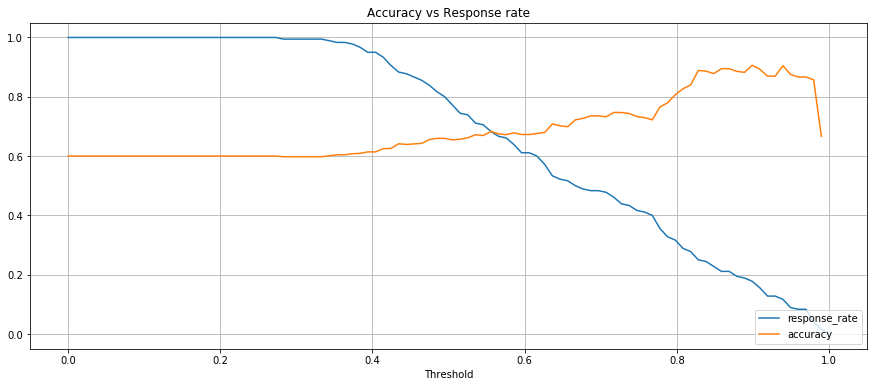

In [11]:
def get_prediction(X, thresh):
    pred = model.predict_proba(X)
    pred = [[(class_id, proba) for (class_id, proba) in enumerate(p) if proba == np.max(p)] for p in pred]
    pred = [p[0][0] if p[0][1]>thresh else 99 for p in pred]
    return np.array(pred)

def get_performance(predictions, labels, thresh):
    """Measure the accuracy and the unknown rate depending on the threshold
    Args:
        predictions: list of tuples (prediction, dist)
        label: list of labels
        thresh: distance threshold above which the prediction becomes unknown
        
    Returns:
        accuracy: proportion of correct predictions when not unkown
        unknown_rate: proportion of predictions that are unknown    
    """
    
    # Measure the rate of known predictions
    response_rate = 1 - np.mean(predictions==99)
    
    # Get the indices of predictions to keep
    known_idx = [i for i in range(len(predictions)) if predictions[i]!=99]
    
    # get predictions that are not unknown
    mini_predictions = np.array([predictions[idx] for idx in known_idx])
    mini_labels = np.array([labels[idx] for idx in known_idx])
    
    # Measure the accuracy
    accuracy = np.mean(mini_predictions == mini_labels)
    
    # Ouput dictionary
    output = {'accuracy': accuracy,
              'response_rate': response_rate}
    
    return output


# Plot the performance against the threshold
accuracy = []
response_rate = []
threshold = np.linspace(start = 0, stop = 1, num=100)

for thresh in threshold:
    predictions = get_prediction(X_test, thresh)
    labels = y_test
    perf = get_performance(predictions, labels, thresh)
    accuracy.append(perf['accuracy'])
    response_rate.append(perf['response_rate'])
    
plt.figure(figsize=(15,6))
plt.plot(threshold, response_rate)
plt.plot(threshold, accuracy)
plt.legend(['response_rate', 'accuracy'], loc='lower right')
plt.title('Accuracy vs Response rate')
plt.xlabel('Threshold')
plt.grid(True)
plt.show()

In [12]:
model.predict(X_test)

array([1, 3, 0, 0, 1, 3, 0, 1, 1, 1, 2, 0, 1, 1, 2, 3, 3, 0, 3, 0, 0, 0,
       1, 3, 3, 0, 1, 0, 1, 3, 2, 3, 3, 3, 3, 1, 0, 3, 3, 3, 3, 0, 0, 2,
       0, 3, 2, 0, 3, 0, 3, 2, 0, 1, 0, 1, 0, 3, 3, 0, 3, 0, 3, 0, 0, 0,
       0, 0, 0, 1, 3, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 3, 0, 1, 0, 0, 0, 0,
       3, 0, 3, 3, 1, 3, 3, 0, 0, 0, 3, 0, 1, 3, 0, 2, 0, 3, 1, 0, 0, 0,
       1, 1, 1, 1, 3, 1, 0, 0, 0, 1, 1, 3, 0, 3, 3, 0, 0, 0, 2, 2, 2, 0,
       3, 2, 1, 0, 3, 0, 1, 1, 1, 0, 0, 3, 1, 0, 0, 1, 3, 0, 1, 3, 0, 0,
       0, 0, 1, 3, 1, 2, 3, 0, 3, 0, 1, 0, 3, 0, 1, 1, 1, 3, 0, 0, 0, 0,
       0, 0, 3, 1])

In [13]:
labels = np.array(test['label'])
labels

array([1, 3, 0, 3, 2, 2, 0, 1, 1, 0, 2, 3, 3, 1, 3, 2, 3, 0, 0, 0, 0, 0,
       0, 3, 0, 0, 0, 3, 3, 1, 2, 3, 0, 3, 3, 1, 0, 3, 3, 3, 3, 1, 0, 2,
       0, 0, 3, 1, 3, 0, 0, 1, 0, 1, 1, 1, 3, 3, 1, 1, 3, 0, 0, 0, 1, 2,
       1, 0, 3, 1, 3, 0, 0, 0, 3, 2, 0, 2, 0, 3, 0, 3, 0, 2, 0, 0, 0, 0,
       3, 0, 2, 3, 3, 1, 0, 3, 0, 0, 3, 0, 1, 2, 1, 0, 1, 2, 0, 0, 0, 0,
       1, 0, 0, 3, 2, 1, 0, 0, 0, 1, 3, 3, 3, 1, 3, 0, 0, 0, 2, 0, 3, 0,
       3, 3, 0, 3, 3, 0, 0, 1, 0, 0, 3, 3, 1, 0, 3, 1, 2, 0, 1, 3, 0, 0,
       1, 0, 1, 1, 1, 2, 1, 0, 3, 0, 0, 0, 3, 0, 0, 1, 1, 3, 1, 3, 3, 0,
       0, 0, 3, 1])

## Accuracy

In [14]:
# Accuracy on modeling set
y_hat_modeling = model.predict(X_modeling)
acc = np.round(np.mean(y_modeling == y_hat_modeling),2)
print("Performance on training set")
print('Accuracy: {}'.format(acc))

Performance on training set
Accuracy: 0.78


In [15]:
# Accuracy on 5-fold cross-validation
print("Performance on validation set")
print('Accuracy: {}'.format(round(clf.best_score_,2)))

Performance on validation set
Accuracy: 0.58


In [16]:
# Accuracy on test set
y_hat_test = model.predict(X_test)
acc = np.round(np.mean(y_test == y_hat_test),2)
print("Performance on test set")
print('Accuracy: {}'.format(acc))

Performance on test set
Accuracy: 0.6


## Confusion Matrix

In [17]:
# Prepare class names for display
class_dict = {0: 'correct', 1:'correct_but_incomplete', 2:'contradictory', 3:'incorrect'}
class_ids = list(np.unique(y_test))
class_names = [class_dict[cid] for cid in class_ids]

Confusion matrix, without normalization
[[53 12  2  7]
 [10 21  1  6]
 [ 1  4  5  7]
 [12  6  4 29]]


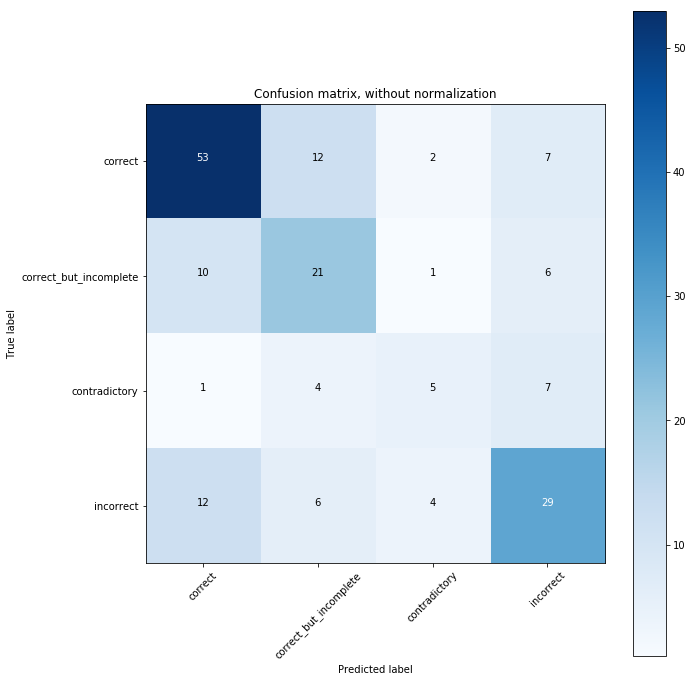

In [18]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_hat_test)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization',
                      cmap=plt.cm.Blues)

## Classification Report

In [19]:
# Compute classification report
clf_report = classification_report(y_test, y_hat_test, target_names=class_names)
print(clf_report)

                        precision    recall  f1-score   support

               correct       0.70      0.72      0.71        74
correct_but_incomplete       0.49      0.55      0.52        38
         contradictory       0.42      0.29      0.34        17
             incorrect       0.59      0.57      0.58        51

             micro avg       0.60      0.60      0.60       180
             macro avg       0.55      0.53      0.54       180
          weighted avg       0.60      0.60      0.60       180

